### 【例 12.12】
### 基于 Spark 的电影推荐。

In [1]:
import numpy as np
import pandas as pd
import os
import zipfile
from urllib.request import urlretrieve
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
# 设置随机种子
np.random.seed(42)

# 1. 下载数据集
url = "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip"
data_dir = "./ml-latest-small"

# 下载并解压数据集
if not os.path.exists(data_dir):
    os.makedirs(data_dir, exist_ok=True)
    #double dictory
    zip_path = os.path.join(data_dir, "ml-latest-small.zip")
    print(f"下载数据集: {url}")
    urlretrieve(url, zip_path)
    
    print("解压数据集...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_dir)
    os.remove(zip_path)
    print("数据集准备完成")

下载数据集: https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
解压数据集...
数据集准备完成


In [3]:
# 数据路径
data_dir = "./ml-latest-small/ml-latest-small"
ratings_path = os.path.join(data_dir, "ratings.csv")
print(ratings_path)

./ml-latest-small/ml-latest-small\ratings.csv


In [4]:
# 2. 加载数据
ratings = pd.read_csv(os.path.join(data_dir, "ratings.csv"))
#ratings = pd.read_csv("ratings.csv")
#ratings = pd.read_csv("ratings.csv", header=None, names=["userId","movieId","rating","timestamp"])
movies = pd.read_csv(os.path.join(data_dir, "movies.csv"))
print(f"数据集包含：\n{len(ratings)} 条评分\n{len(movies)} 部电影")

数据集包含：
100836 条评分
9742 部电影


In [5]:
# 合并电影标题到评分数据
ratings_with_title = ratings.merge(movies[['movieId', 'title']], on='movieId', how='left')
print("评分数据包含电影标题")

评分数据包含电影标题



数据探索:
总评分数量: 100836
唯一用户数: 610
唯一电影数: 9724


C:\Users\baixiong\AppData\Local\Temp\ipykernel_13836\2321478154.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='rating', data=ratings_with_title, palette='viridis')


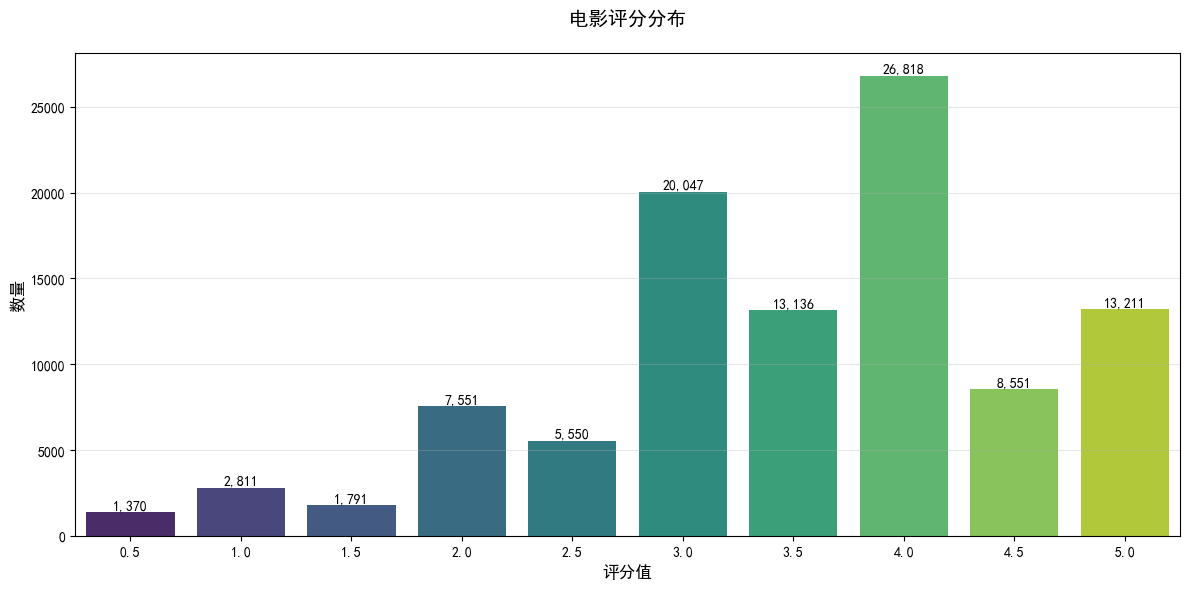

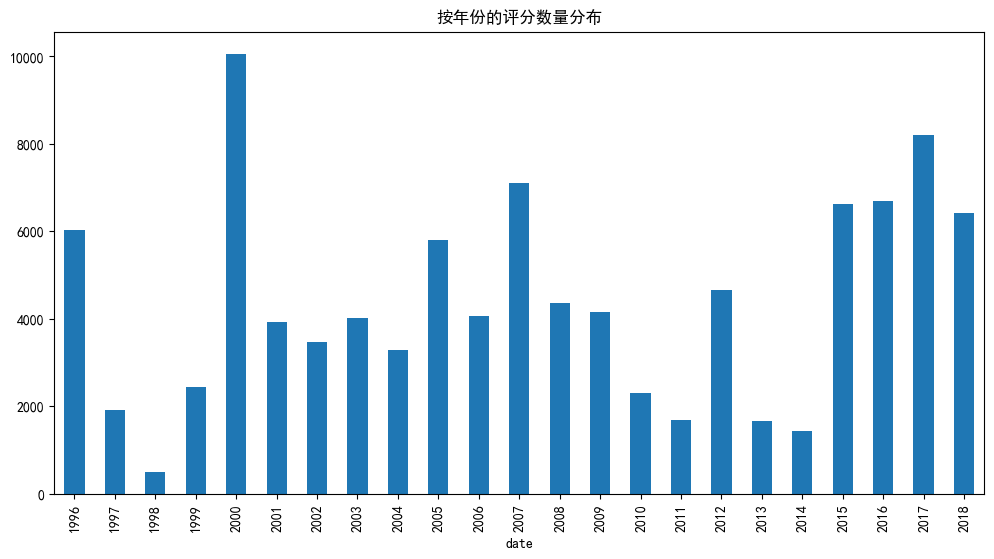

In [13]:
# 3. 数据探索
# 检查并修复列名
ratings_with_title.columns = ratings_with_title.columns.str.strip()
movies.columns = movies.columns.str.strip()

# 设置中文显示
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['axes.unicode_minus'] = False

print("\n数据探索:")
print(f"总评分数量: {len(ratings_with_title)}")
print(f"唯一用户数: {ratings_with_title['userId'].nunique()}")
print(f"唯一电影数: {ratings_with_title['movieId'].nunique()}")

# 检查评分范围
assert ratings_with_title['rating'].min() >= 0, "存在负分异常值"
assert ratings_with_title['rating'].max() <= 5, "存在超过5分的异常值"

# 评分分布可视化
plt.figure(figsize=(12, 6))
ax = sns.countplot(x='rating', data=ratings_with_title, palette='viridis')

# 添加数据标签
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.title('电影评分分布', fontsize=14, pad=20)
plt.xlabel('评分值', fontsize=12)
plt.ylabel('数量', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('rating_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# 如果有时间戳数据，分析时间趋势
if 'timestamp' in ratings_with_title.columns:
    ratings_with_title['date'] = pd.to_datetime(ratings_with_title['timestamp'], unit='s')
    plt.figure(figsize=(12,6))
    ratings_with_title['date'].dt.year.value_counts().sort_index().plot(kind='bar')
    plt.title('按年份的评分数量分布')
    plt.savefig('ratings_by_year.png', dpi=300, bbox_inches='tight')
    plt.show()


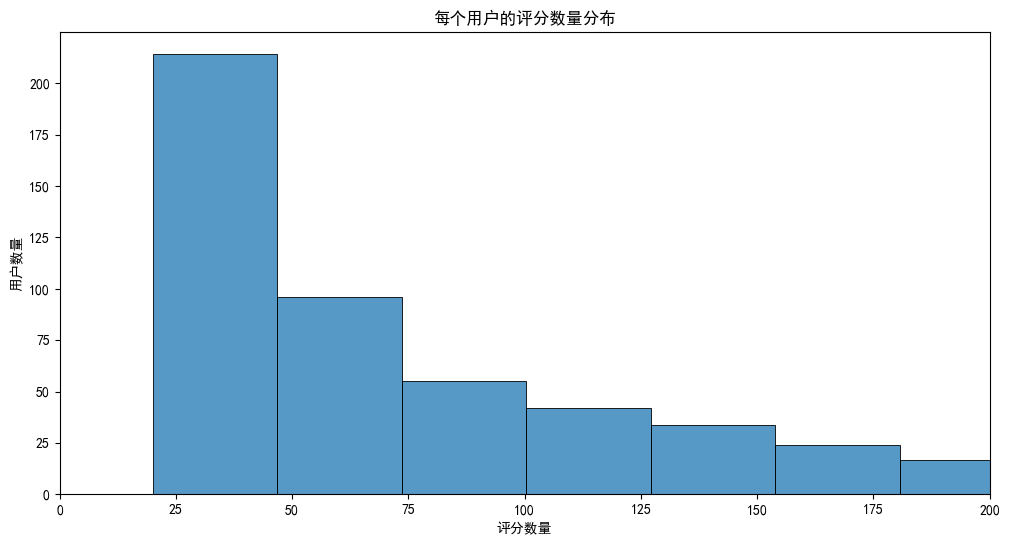

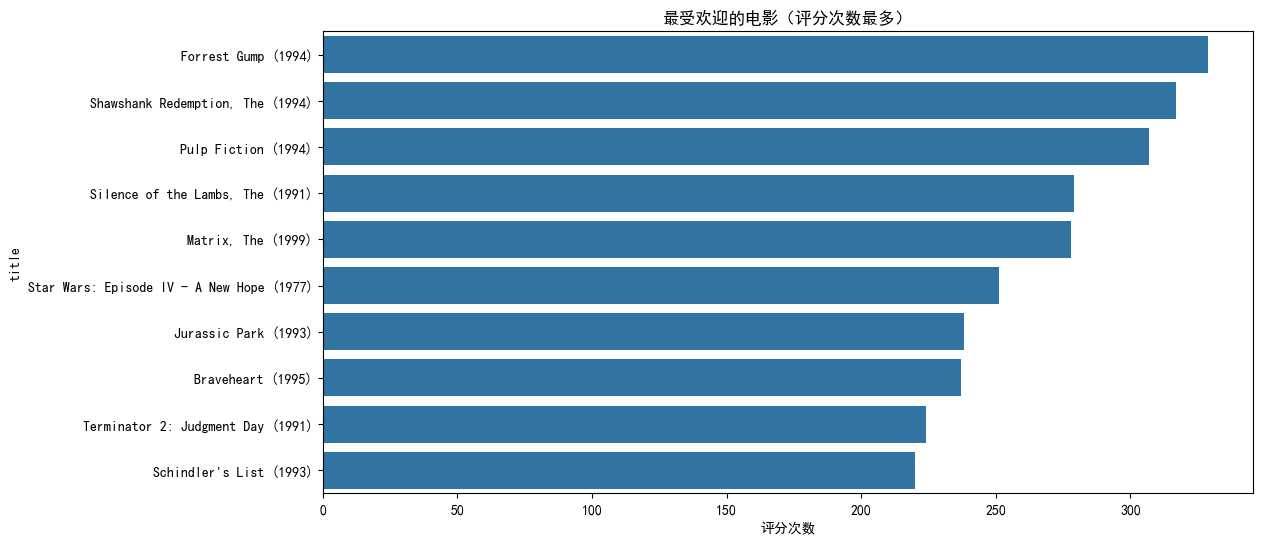

In [7]:
# 每个用户的评分数量
user_ratings_count = ratings_with_title['userId'].value_counts()
plt.figure(figsize=(12, 6))
sns.histplot(user_ratings_count, bins=100)
plt.title('每个用户的评分数量分布')
plt.xlabel('评分数量')
plt.ylabel('用户数量')
plt.xlim(0, 200)
plt.savefig('user_ratings_distribution.png')  # 保存图像
plt.show()

# 最受欢迎的电影（评分次数最多）
top_movies = ratings_with_title['title'].value_counts().head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_movies.values, y=top_movies.index)
plt.title('最受欢迎的电影（评分次数最多）')
plt.xlabel('评分次数')
plt.savefig('top_movies.png')  # 保存图像
plt.show()

In [9]:
# 4. 数据预处理
print("\n数据预处理...")
# 过滤掉评分次数过少的用户和电影
min_user_ratings = 20
min_movie_ratings = 10

filtered_users = user_ratings_count[user_ratings_count >= min_user_ratings].index
filtered_ratings = ratings_with_title[ratings_with_title['userId'].isin(filtered_users)]

movie_ratings_count = filtered_ratings['movieId'].value_counts()
filtered_movies = movie_ratings_count[movie_ratings_count >= min_movie_ratings].index
filtered_ratings = filtered_ratings[filtered_ratings['movieId'].isin(filtered_movies)]

print(f"过滤后数据集：\n{len(filtered_ratings)} 条评分\n{len(filtered_ratings['userId'].unique())} 位用户\n{len(filtered_ratings['movieId'].unique())} 部电影")

# 创建用户-电影评分矩阵
ratings_matrix = filtered_ratings.pivot_table(
    index='userId', 
    columns='movieId', 
    values='rating'
).fillna(0)

print(f"评分矩阵形状: {ratings_matrix.shape}")



数据预处理...
过滤后数据集：
81116 条评分
610 位用户
2269 部电影
评分矩阵形状: (610, 2269)


In [18]:
# 5. 构建协同过滤模型
print("\n构建推荐模型...")
start_time = time.time()

# 将评分矩阵转换为稀疏矩阵以提高效率
sparse_ratings = csr_matrix(ratings_matrix.values)

# 使用KNN算法找到相似用户
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
model_knn.fit(sparse_ratings)

print(f"模型构建完成，耗时: {time.time() - start_time:.2f}秒")


构建推荐模型...
模型构建完成，耗时: 0.08秒


In [19]:
# 6. 推荐函数
def recommend_movies(user_id, n_recommendations=10):
    """
    为指定用户推荐电影
    
    参数:
    user_id -- 要推荐的用户ID
    n_recommendations -- 推荐电影数量
    """
    # 检查用户是否在过滤后的数据集中
    if user_id not in ratings_matrix.index:
        print(f"用户 {user_id} 不在过滤后的数据集中，无法生成推荐")
        return pd.DataFrame()
    
    print(f"为用户 {user_id} 生成推荐...")
    start_time = time.time()
    
    # 获取用户评分数据
    user_ratings = ratings_matrix.loc[user_id].values.reshape(1, -1)
    
    # 找到相似用户
    distances, indices = model_knn.kneighbors(user_ratings, n_neighbors=20)
    
    # 获取相似用户的评分
    similar_users = ratings_matrix.iloc[indices[0]].index
    similar_users_ratings = ratings_matrix[ratings_matrix.index.isin(similar_users)]
    
    # 计算电影的平均评分（排除当前用户）
    movie_avg_ratings = similar_users_ratings[similar_users_ratings.index != user_id].mean(axis=0)
    
    # 获取用户已经看过的电影
    watched_movies = ratings_matrix.loc[user_id][ratings_matrix.loc[user_id] > 0].index
    
    # 过滤掉用户已经看过的电影，并按评分排序
    recommendations = movie_avg_ratings.drop(watched_movies, errors='ignore')
    recommendations = recommendations.sort_values(ascending=False).head(n_recommendations)
    
    # 将推荐结果转换为DataFrame
    recommendations = recommendations.reset_index()
    recommendations.columns = ['movieId', 'predicted_rating']
    recommendations = recommendations.merge(movies, on='movieId')
    
    print(f"推荐生成完成，耗时: {time.time() - start_time:.2f}秒")
    return recommendations

In [20]:
# 7. 评估函数
def evaluate_recommendations(user_id, n_recommendations=10, test_size=0.2):
    """
    评估推荐质量
    
    参数:
    user_id -- 要评估的用户ID
    n_recommendations -- 推荐电影数量
    test_size -- 测试集比例
    """
    # 检查用户是否在过滤后的数据集中
    if user_id not in ratings_matrix.index:
        print(f"用户 {user_id} 不在过滤后的数据集中，无法评估")
        return 0.0
    
    # 获取用户评分数据
    user_data = filtered_ratings[filtered_ratings['userId'] == user_id]
    
    # 如果用户评分太少，无法分割
    if len(user_data) < 5:
        print(f"用户 {user_id} 评分太少 ({len(user_data)} 条)，无法评估")
        return 0.0
    
    print(f"评估用户 {user_id} 的推荐质量...")
    start_time = time.time()
    
    # 分割训练集和测试集
    train_data = user_data.sample(frac=1-test_size, random_state=42)
    test_data = user_data.drop(train_data.index)
    
    # 如果测试集为空
    if len(test_data) == 0:
        print(f"用户 {user_id} 测试集为空")
        return 0.0
    
    # 临时移除测试集评分
    temp_ratings = ratings_matrix.copy()
    for _, row in test_data.iterrows():
        temp_ratings.loc[user_id, row['movieId']] = 0
    
    # 使用训练后的模型进行推荐
    temp_ratings_matrix = temp_ratings
    temp_sparse_ratings = csr_matrix(temp_ratings_matrix.values)
    temp_model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
    temp_model.fit(temp_sparse_ratings)
    
    # 获取用户评分数据
    user_ratings = temp_ratings_matrix.loc[user_id].values.reshape(1, -1)
    
    # 找到相似用户
    distances, indices = temp_model.kneighbors(user_ratings, n_neighbors=20)
    
    # 获取相似用户的评分
    similar_users = temp_ratings_matrix.iloc[indices[0]].index
    similar_users_ratings = temp_ratings_matrix[temp_ratings_matrix.index.isin(similar_users)]
    
    # 计算电影的平均评分
    movie_avg_ratings = similar_users_ratings[similar_users_ratings.index != user_id].mean(axis=0)
    

    # 获取用户已经看过的电影（训练集）
    watched_movies = train_data['movieId'].tolist()
    
    # 生成推荐
    recommendations = movie_avg_ratings.drop(watched_movies, errors='ignore')
    recommendations = recommendations.sort_values(ascending=False).head(n_recommendations)
    recommendations = recommendations.index.tolist()
    
    # 计算命中率
    hits = set(recommendations) & set(test_data['movieId'])
    hit_rate = len(hits) / min(len(test_data), n_recommendations)
    
    print(f"评估完成，耗时: {time.time() - start_time:.2f}秒")
    return hit_rate

In [21]:
# 8. 示例推荐
# 选择一个有足够评分的用户
active_users = filtered_ratings['userId'].value_counts().head(10).index
user_id = np.random.choice(active_users)
print(f"\n为用户 {user_id} 生成推荐:")

# 获取用户已观看的电影
watched_movies = filtered_ratings[filtered_ratings['userId'] == user_id]
print("\n用户已观看的电影:")
print(watched_movies[['title', 'rating']].sort_values('rating', ascending=False).head(10).to_string(index=False))

# 生成推荐
recommendations = recommend_movies(user_id, 10)
if not recommendations.empty:
    print("\nTop 10 推荐:")
    print(recommendations[['title', 'genres', 'predicted_rating']].sort_values('predicted_rating', ascending=False).to_string(index=False))
    
    # 保存推荐结果
    recommendations.to_csv(f'recommendations_for_user_{user_id}.csv', index=False)
    print(f"推荐结果已保存到 recommendations_for_user_{user_id}.csv")
else:
    print("无法生成推荐")


为用户 380 生成推荐:

用户已观看的电影:
                                                         title  rating
                     Twelve Monkeys (a.k.a. 12 Monkeys) (1995)     5.0
                                            Equilibrium (2002)     5.0
                 Lord of the Rings: The Two Towers, The (2002)     5.0
                  My Neighbor Totoro (Tonari no Totoro) (1988)     5.0
                                      Road to Perdition (2002)     5.0
          Spirited Away (Sen to Chihiro no kamikakushi) (2001)     5.0
                             Die Hard: With a Vengeance (1995)     5.0
                     Star Wars: Episode IV - A New Hope (1977)     5.0
Léon: The Professional (a.k.a. The Professional) (Léon) (1994)     5.0
                                           Pulp Fiction (1994)     5.0
为用户 380 生成推荐...
推荐生成完成，耗时: 0.12秒

Top 10 推荐:
                                       title                   genres  predicted_rating
                      American Beauty (1999)            Dram

In [22]:
# 9. 评估推荐质量
print("\n评估推荐质量...")
hit_rates = []
evaluated_users = np.random.choice(active_users, size=min(10, len(active_users)), replace=False)

for user in evaluated_users:
    hit_rate = evaluate_recommendations(user, 10)
    hit_rates.append(hit_rate)
    print(f"用户 {user} 的命中率: {hit_rate:.2f}")

if hit_rates:
    avg_hit_rate = np.mean(hit_rates)
    print(f"\n平均命中率: {avg_hit_rate:.2f}")
    
    # 保存评估结果
    eval_results = pd.DataFrame({
        'user_id': evaluated_users,
        'hit_rate': hit_rates
    })
    eval_results.to_csv('recommendation_evaluation.csv', index=False)
    print("评估结果已保存到 recommendation_evaluation.csv")


评估推荐质量...
评估用户 274 的推荐质量...
评估完成，耗时: 0.13秒
用户 274 的命中率: 0.90
评估用户 414 的推荐质量...
评估完成，耗时: 0.07秒
用户 414 的命中率: 0.90
评估用户 610 的推荐质量...
评估完成，耗时: 0.08秒
用户 610 的命中率: 1.00
评估用户 380 的推荐质量...
评估完成，耗时: 0.06秒
用户 380 的命中率: 1.00
评估用户 68 的推荐质量...
评估完成，耗时: 0.06秒
用户 68 的命中率: 1.00
评估用户 599 的推荐质量...
评估完成，耗时: 0.07秒
用户 599 的命中率: 1.00
评估用户 249 的推荐质量...
评估完成，耗时: 0.08秒
用户 249 的命中率: 1.00
评估用户 448 的推荐质量...
评估完成，耗时: 0.08秒
用户 448 的命中率: 0.50
评估用户 288 的推荐质量...
评估完成，耗时: 0.07秒
用户 288 的命中率: 0.50
评估用户 474 的推荐质量...
评估完成，耗时: 0.07秒
用户 474 的命中率: 1.00

平均命中率: 0.88
评估结果已保存到 recommendation_evaluation.csv


In [23]:
# 10. 电影相似度推荐（基于物品的协同过滤）
def similar_movies(movie_title, n_recommendations=10):
    """
    查找相似电影
    
    参数:
    movie_title -- 目标电影标题
    n_recommendations -- 推荐电影数量
    """
    # 查找电影ID
    movie_match = movies[movies['title'] == movie_title]
    
    if movie_match.empty:
        print(f"找不到电影: {movie_title}")
        return pd.DataFrame()
    
    movie_id = movie_match.iloc[0]['movieId']
    
    # 检查电影是否在数据集中
    if movie_id not in filtered_ratings['movieId'].values:
        print(f"电影 '{movie_title}' 不在过滤后的数据集中")
        return pd.DataFrame()
    
    print(f"查找与 '{movie_title}' 相似的电影...")
    start_time = time.time()
    
    # 创建电影-用户评分矩阵
    movie_ratings_matrix = filtered_ratings.pivot_table(
        index='movieId', 
        columns='userId', 
        values='rating'
    ).fillna(0)
    
    # 转换为稀疏矩阵
    sparse_movie_ratings = csr_matrix(movie_ratings_matrix.values)
    
    # 使用KNN算法找到相似电影
    model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=n_recommendations+1, n_jobs=-1)
    model_knn.fit(sparse_movie_ratings)
    
    # 获取目标电影的评分数据
    movie_idx = movie_ratings_matrix.index.get_loc(movie_id)
    movie_ratings = movie_ratings_matrix.iloc[movie_idx].values.reshape(1, -1)
    
    # 找到相似电影
    distances, indices = model_knn.kneighbors(movie_ratings, n_neighbors=n_recommendations+1)
    
    # 获取相似电影的ID
    similar_indices = indices[0][1:]  # 排除第一个（自身）
    similar_movie_ids = movie_ratings_matrix.index[similar_indices]
    
    # 计算相似度
    similarities = 1 - distances[0][1:]
    
    # 创建结果DataFrame
    similar_movies_df = pd.DataFrame({
        'movieId': similar_movie_ids,
        'similarity': similarities
    })
    
    # 合并电影信息
    similar_movies_df = similar_movies_df.merge(movies, on='movieId')
    
    print(f"相似电影查找完成，耗时: {time.time() - start_time:.2f}秒")
    return similar_movies_df

In [24]:
# 示例：查找与特定电影相似的电影
movie_title = "Toy Story (1995)"
print(f"\n查找与 '{movie_title}' 相似的电影:")
similar_movies_df = similar_movies(movie_title, 10)

if not similar_movies_df.empty:
    print("\n相似电影:")
    print(similar_movies_df[['title', 'genres', 'similarity']].sort_values('similarity', ascending=False).to_string(index=False))
    
    # 保存相似电影结果
    similar_movies_df.to_csv(f'similar_to_{movie_title.replace(" ", "_")}.csv', index=False)
    print(f"相似电影结果已保存到 similar_to_{movie_title.replace(' ', '_')}.csv")
else:
    print("无法找到相似电影")

# 11. 保存处理后的数据
print("\n保存处理后的数据...")
filtered_ratings.to_csv('filtered_ratings.csv', index=False)
movies.to_csv('movies.csv', index=False)
print("数据已保存")


查找与 'Toy Story (1995)' 相似的电影:
查找与 'Toy Story (1995)' 相似的电影...
相似电影查找完成，耗时: 0.17秒

相似电影:
                                            title                                          genres  similarity
                               Toy Story 2 (1999)     Adventure|Animation|Children|Comedy|Fantasy    0.572601
                             Jurassic Park (1993)                Action|Adventure|Sci-Fi|Thriller    0.565637
             Independence Day (a.k.a. ID4) (1996)                Action|Adventure|Sci-Fi|Thriller    0.564262
        Star Wars: Episode IV - A New Hope (1977)                         Action|Adventure|Sci-Fi    0.557388
                              Forrest Gump (1994)                        Comedy|Drama|Romance|War    0.547096
                            Lion King, The (1994) Adventure|Animation|Children|Drama|Musical|IMAX    0.541145
Star Wars: Episode VI - Return of the Jedi (1983)                         Action|Adventure|Sci-Fi    0.541089
                       Mission: